In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cmasher as cmr

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'
pd.set_option('display.precision', 4)

ROOT = Path("..").resolve().parent

loops = 1
aggr = "multi"

results_dir = f"{ROOT}/results/predicting-Mstar/gnns-upgraded_{aggr}_loops-{loops}"

In [2]:
def rmse(p, y): return ((p - y) ** 2).mean()**0.5

In [3]:
D_links = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5]     


# Lowest RMSE vs linking length

In [4]:

results = dict()

print(f"===== GNN RESULTS =====".center(72))
linking_length_results = list()
for D in D_links:
    df = pd.read_csv(f"{results_dir}/r_link{D}/cross-validation.csv")
    individual_experiment_results = list()
    for y_col in ["p_GNN_3d", "p_GNN_2d", "p_RF_Mhalo", "p_RF_Vmax", "p_RF_MhVmax", "p_RF_overdensity"]:
        individual_experiment_results.append(rmse(df[y_col], df["log_Mstar"]))
    linking_length_results.append(individual_experiment_results)
        
results_experiment = pd.DataFrame(
    linking_length_results, 
    columns=["GNN-3d", "GNN-2d", "RF-Mh", "RF-Vmax", "RF-MhVmax", "RF-overdensity"],
    index=D_links
)
print(results_experiment)

                        ===== GNN RESULTS =====                         
     GNN-3d  GNN-2d   RF-Mh  RF-Vmax  RF-MhVmax  RF-overdensity
0.3  0.1385  0.1374  0.3742   0.1981     0.1480          0.1430
0.5  0.1367  0.1369  0.3742   0.1981     0.1481          0.1423
1.0  0.1344  0.1355  0.3742   0.1981     0.1480          0.1393
1.5  0.1322  0.1324  0.3743   0.1982     0.1481          0.1366
2.0  0.1323  0.1340  0.3742   0.1981     0.1480          0.1354
2.5  0.1305  0.1341  0.3743   0.1981     0.1481          0.1347
3.0  0.1310  0.1341  0.3742   0.1981     0.1480          0.1350
3.5  0.1330  0.1360  0.3742   0.1981     0.1480          0.1352
4.0  0.1333  0.1346  0.3742   0.1981     0.1480          0.1356
5.0  0.1326  0.1371  0.3742   0.1981     0.1480          0.1363


Split k-fold validation results

In [5]:
def get_rmse_kfold(k, D):
    df_3d = pd.read_csv(f"{results_dir}/r_link{D}/validation-fold{k}.csv")
    df_2d = pd.read_csv(f"{results_dir}/r_link{D}/validation-projected-fold{k}.csv")
    return (
        rmse(df_3d["p_GNN_3d"], df_3d["log_Mstar"]), 
        rmse(df_2d["p_GNN_2d"], df_2d["log_Mstar"]),
        rmse(df_3d["p_RF_overdensity"], df_3d["log_Mstar"])
    )
        


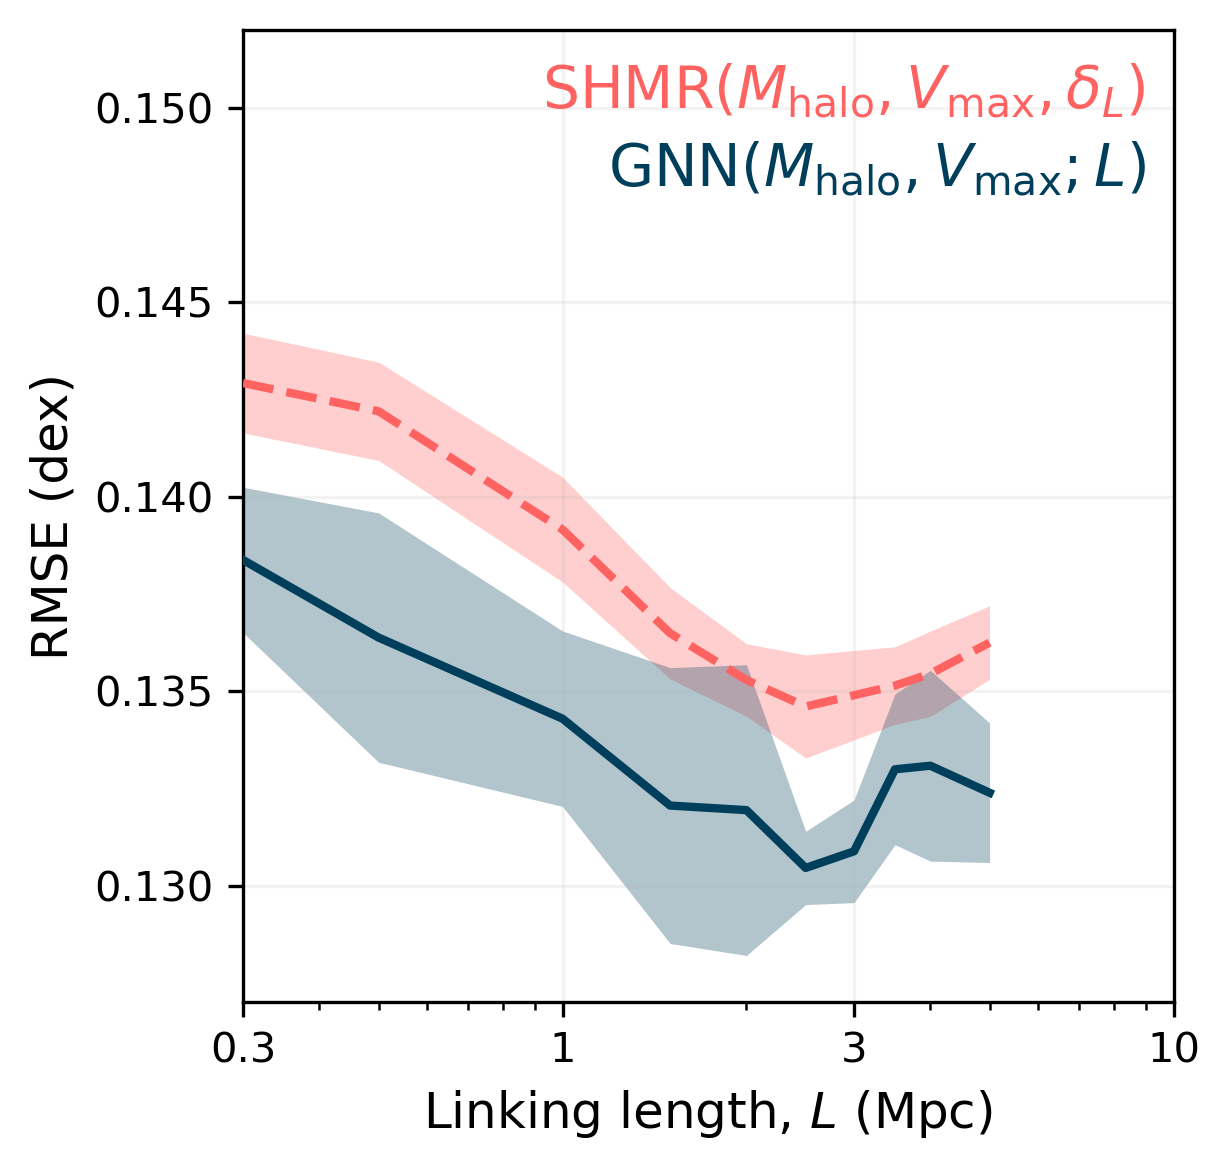

In [6]:
plt.figure(figsize=(4.2, 4.), dpi=300)

rmse_3d, rmse_2d, rmse_overdensity = [], [], []

for D in D_links:
    res_k = np.array(list(get_rmse_kfold(k, D) for k in range(1,7))).T
    rmse_3d.append(res_k[0])
    rmse_2d.append(res_k[1])
    rmse_overdensity.append(res_k[2])

plt.plot(D_links, np.mean(rmse_overdensity, 1), c=c3, lw=2, ls="--", zorder=4)
plt.fill_between(D_links, np.mean(rmse_overdensity, 1)-np.std(rmse_overdensity, 1), np.mean(rmse_overdensity, 1)+np.std(rmse_overdensity, 1), color=c3, alpha=0.3, lw=0)

# plt.plot(D_links, np.mean(rmse_2d, 1), c=c3, lw=2, zorder=2)
# plt.fill_between(D_links, np.mean(rmse_2d, 1)-np.std(rmse_2d, 1), np.mean(rmse_2d, 1)+np.std(rmse_2d, 1), color=c3, alpha=0.3, lw=0)

plt.plot(D_links, np.mean(rmse_3d, 1), c=c0, lw=2, zorder=3)
plt.fill_between(D_links, np.mean(rmse_3d, 1)-np.std(rmse_3d, 1), np.mean(rmse_3d, 1)+np.std(rmse_3d, 1), color=c0, alpha=0.3, lw=0)

plt.text(0.97, 0.92, "SHMR($M_{\\rm halo},V_{\\rm max},\\delta_L$)", ha="right", transform=plt.gca().transAxes, fontsize=14, color=c3)
# plt.text(0.97, 0.84, "GNN$2d$($M_{\\rm halo},V_{\\rm max};L$)", ha="right", transform=plt.gca().transAxes, fontsize=14, color=c3)
plt.text(0.97, 0.84, "GNN($M_{\\rm halo},V_{\\rm max};L$)", ha="right", transform=plt.gca().transAxes, fontsize=14, color=c0)

# plt.legend(loc="upper right", framealpha=0, fontsize=12, markerfirst=False)
plt.xscale("log")
plt.xticks(ticks=[0.3, 1, 3, 10], labels=[0.3, 1, 3, 10])
plt.grid(alpha=0.15)
plt.xlabel("Linking length, $L$ (Mpc)", fontsize=12)
plt.ylabel("RMSE (dex)", fontsize=12)
plt.ylim(0.127, 0.152)
plt.xlim(0.3, 10)
plt.tight_layout()
# plt.savefig(f"{results_dir}/GNN_linking_length.pdf")

# Condition also on halo mass

<Axes: >

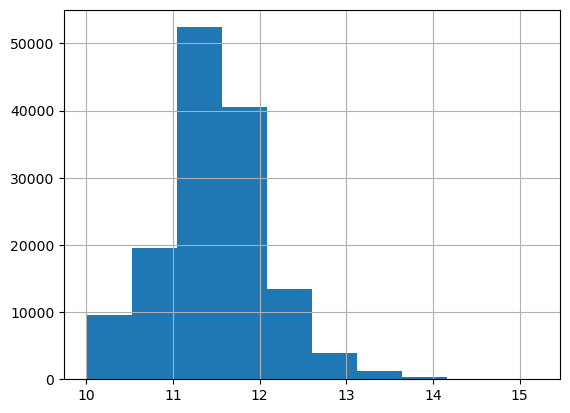

In [8]:
df.log_Mhalo.hist()

Text(0, 0.5, 'Mstar')

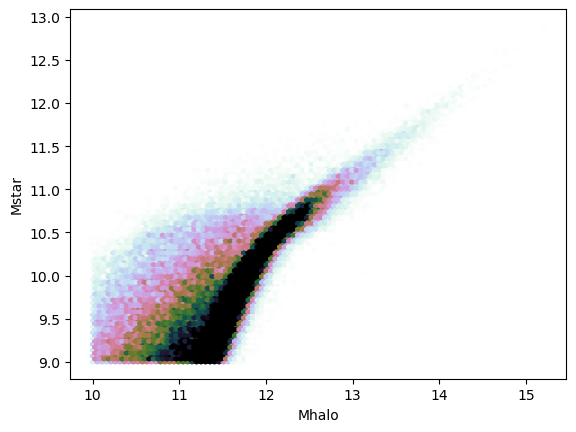

In [9]:
plt.hexbin(df.log_Mhalo, df.log_Mstar, cmap="cubehelix_r", vmax=100)
plt.xlabel("Mhalo")
plt.ylabel("Mstar")

In [10]:
mass_bins = np.arange(10, 14, 0.5)

rmse_grid_GNN3d = np.zeros((len(D_links), len(mass_bins)))
rmse_grid_GNN2d = np.zeros_like(rmse_grid_GNN3d)
rmse_grid_overdensity = np.zeros_like(rmse_grid_GNN3d)

for i, D in enumerate(D_links):
    df = pd.read_csv(f"{results_dir}/r_link{D}/cross-validation.csv")
    for j, (m1, m2) in enumerate(zip(mass_bins, mass_bins+0.5)):

        df_ = df[(df.log_Mhalo > m1) & (df.log_Mhalo <= m2)]
        rmse_grid_GNN3d[i, j] = rmse(df_.p_GNN_3d, df_.log_Mstar)
        rmse_grid_GNN2d[i, j] = rmse(df_.p_GNN_2d, df_.log_Mstar)
        rmse_grid_overdensity[i, j] = rmse(df_.p_RF_overdensity, df_.log_Mstar)


Text(0.5, 1.0, 'GNN 3d')

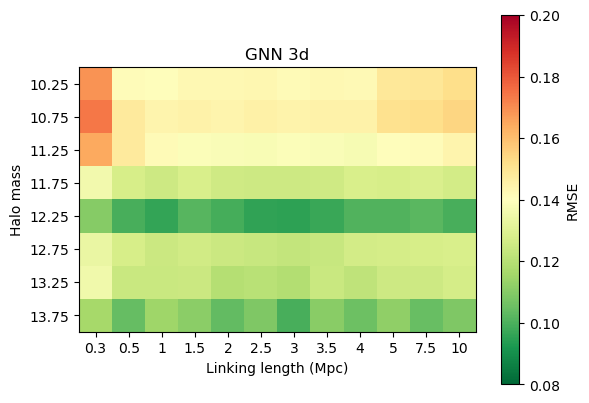

In [11]:
plt.imshow(rmse_grid_GNN3d.T, vmin=0.08, vmax=0.2, cmap="RdYlGn_r")
cb = plt.colorbar()
cb.set_label("RMSE")

plt.xticks(ticks=range(len(D_links)), labels=D_links)
plt.xlabel("Linking length (Mpc)")

plt.yticks(ticks=range(len(mass_bins)), labels=mass_bins+0.25)
plt.ylabel("Halo mass")
plt.title("GNN 3d")

Text(0.5, 1.0, 'GNN 2d')

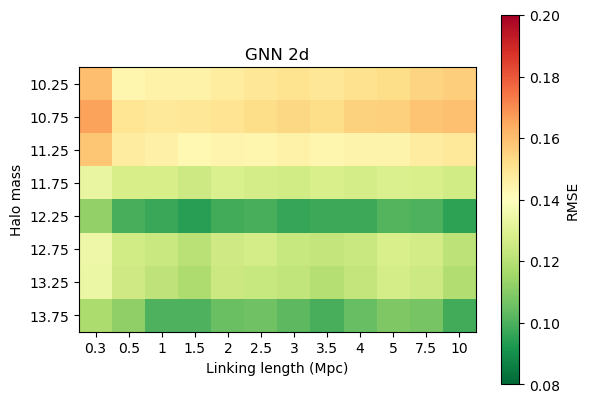

In [12]:
plt.imshow(rmse_grid_GNN2d.T, vmin=0.08, vmax=0.2, cmap="RdYlGn_r")
cb = plt.colorbar()
cb.set_label("RMSE")

plt.xticks(ticks=range(len(D_links)), labels=D_links)
plt.xlabel("Linking length (Mpc)")

plt.yticks(ticks=range(len(mass_bins)), labels=mass_bins+0.25)
plt.ylabel("Halo mass")
plt.title("GNN 2d")

Text(0.5, 1.0, 'RF with overdensity')

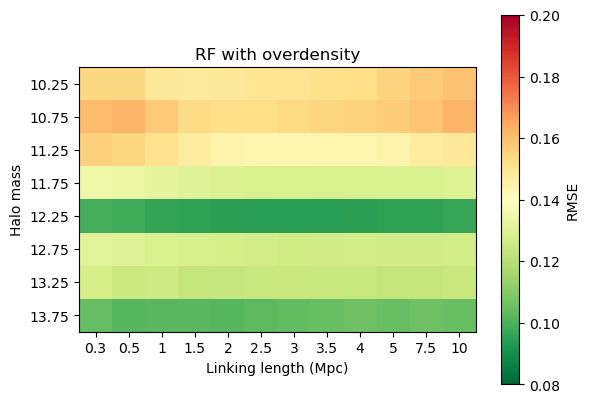

In [13]:
plt.imshow(rmse_grid_overdensity.T, vmin=0.08, vmax=0.2, cmap="RdYlGn_r")
cb = plt.colorbar()
cb.set_label("RMSE")

plt.xticks(ticks=range(len(D_links)), labels=D_links)
plt.xlabel("Linking length (Mpc)")

plt.yticks(ticks=range(len(mass_bins)), labels=mass_bins+0.25)
plt.ylabel("Halo mass")
plt.title("RF with overdensity")